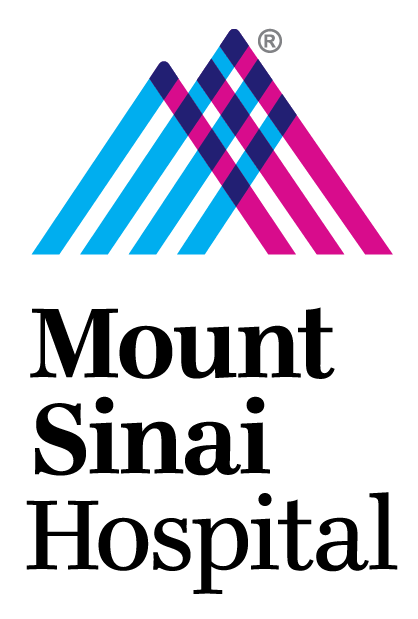

# Predicting Peumonia with X-Ray Images for Mt. Sinai Hospital
Authored by Jae Heon Kim

## Overview


The goal of this project is to build a deep learning model that can accurately predict the presence of pneumonia in patients based on their chest X-ray images. The model will be used by medical professionals at Mt Sinai Hospital to improve the accuracy of pneumonia diagnoses and reduce the number of false positives generated by current detection methods.

To achieve this, we will preprocess the chest X-ray images and extract features using convolutional neural networks. We will then train and validate the model using a dataset of chest X-ray images of normal people and people with pneumonia. Once the model is trained, we will evaluate its performance on a separate test dataset and optimize its hyperparameters to achieve the desired level of accuracy and minimize false negatives.

The final model will be a valuable tool for medical professionals, enabling them to quickly and accurately diagnose pneumonia in patients and provide timely treatment, without subjecting healthy individuals to unnecessary second-level pneumonia screening.

## Business Understanding
The objective of this project is to create a deep learning model that can accurately diagnose pneumonia in patients based on their chest X-ray images. The primary stakeholders of this project are the medical professionals at Mt Sinai Hospital, who are seeking a reliable and efficient means of diagnosing pneumonia in patients.

Our goal is to develop a highly accurate model that prioritizes the reduction of false positives, as this can help medical professionals to quickly identify and treat patients with pneumonia while minimizing the need for unnecessary follow-up testing for those who do not have pneumonia.

Reducing false positives can have significant benefits for the hospital, including improved operational efficiency, reduced costs, and increased patient satisfaction. By enabling faster and more accurate diagnoses, our deep learning model can streamline the diagnosis process and help medical staff to better manage their resources and workload.

In addition to these benefits, our model can also improve patient outcomes by facilitating earlier treatment for patients with pneumonia, which can lead to faster recovery times and improved overall health. By improving the accuracy and efficiency of pneumonia diagnoses at Mt Sinai Hospital, our deep learning model can make a valuable contribution to the field of medical diagnosis and help to improve patient care.

## Data Understanding
### Data Description
The dataset contains chest X-ray images (anterior-posterior) of pediatric patients between the ages of one to five years old, obtained from Guangzhou Women and Children's Medical Center, Guangzhou.

The data is available on Kaggle at the following link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia.

The dataset is organized into three folders (train, test, val) and includes subfolders for each image category (Pneumonia/Normal). There are a total of 5,863 JPEG images in the dataset, which have been pre-screened for quality control by removing all low-quality or unreadable scans.

The diagnoses for each image have been graded by two expert physicians to ensure accuracy and reliability. To account for any grading errors, the evaluation set has also been checked by a third expert. The dataset is intended for use in training and evaluating AI systems for the detection of pneumonia in chest X-ray images.

The data is available under a Creative Commons Attribution 4.0 license, and the original source of the data is the Guangzhou Women and Children's Medical Center, Guangzhou. A citation for the dataset is available in a research article published in the journal Cell, and the dataset is also available on Mendeley Data.



### Imports

In [1]:
# Import basic packages
import numpy as np
import pandas as pd

# Import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import sklearn packages
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Import image processing
from PIL import Image, ImageOps

# Import tensorflow pacakges
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import load_img, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.metrics import Precision, Recall

# Import miscellaneous packages
import os
import random
import shutil

### Observing Raw Data

We will first visualize data in its raw form.
Let's start by randomly pulling 10 images from normal, pneumonia respectively and see if we can easily tell the visual difference.

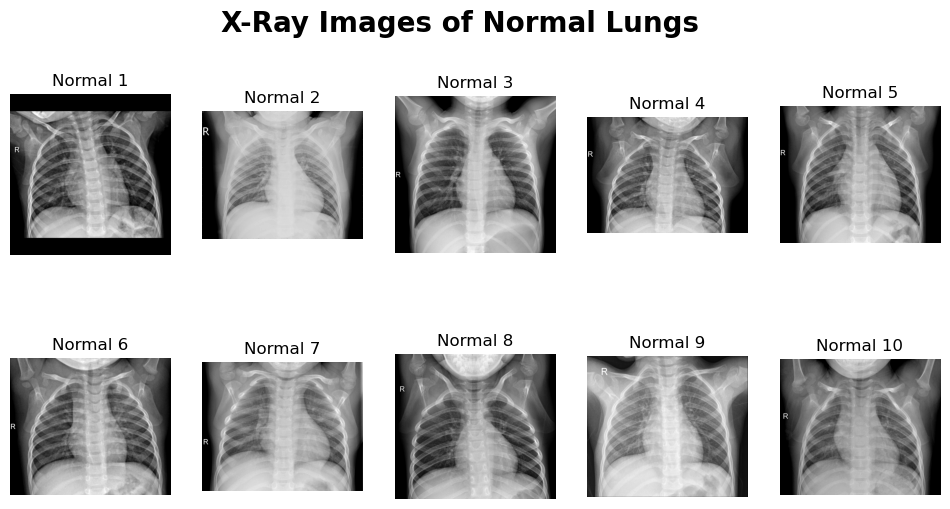

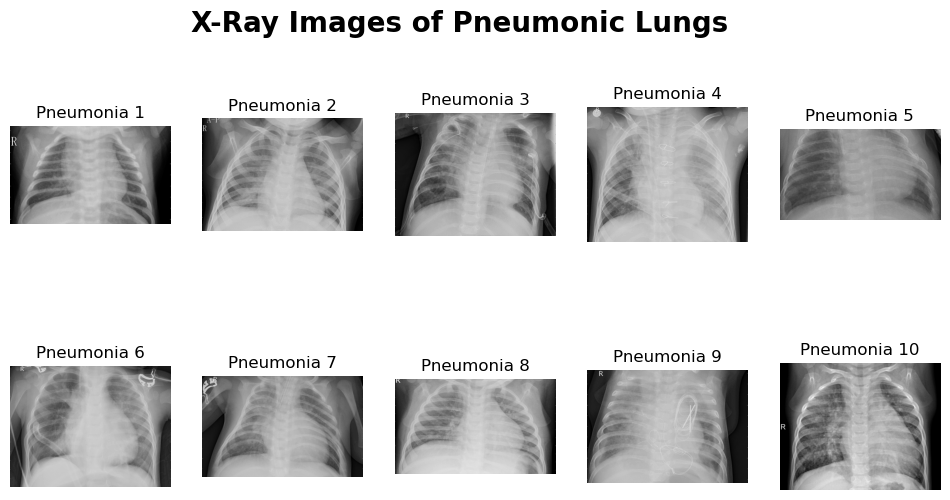

In [2]:
# Assign directory paths for NORMAL and PNEUMONIA within train_dir
normal_dir = 'data/original/train/NORMAL'
pneumonia_dir = 'data/original/train/PNEUMONIA'

# Get a list of file names for 10 random pneumonia images from train data
normal_files = os.listdir(normal_dir)
random.shuffle(normal_files)
normal_files_10 = normal_files[:10]

# Get a list of file names for 10 random pneumonia images from train data
pneumonia_files = os.listdir(pneumonia_dir)
random.shuffle(pneumonia_files)
pneumonia_files_10 = pneumonia_files[:10]

# Plot the 10 normal images
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    image_path_normal = os.path.join(normal_dir, normal_files_10[i])
    image_normal = plt.imread(image_path_normal)
    ax[row, col].imshow(image_normal, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f'Normal {i+1}')
plt.suptitle("X-Ray Images of Normal Lungs", fontsize=20, fontweight='bold')
plt.show()
print("\n\n\n")

# Plot the 10 pneumonia images
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    row = i // 5
    col = i % 5
    image_path_pneumonia = os.path.join(pneumonia_dir, pneumonia_files_10[i])
    image_pneumonia = plt.imread(image_path_pneumonia)
    ax[row, col].imshow(image_pneumonia, cmap='gray')
    ax[row, col].axis('off')
    ax[row, col].set_title(f'Pneumonia {i+1}')
plt.suptitle("X-Ray Images of Pneumonic Lungs", fontsize=20, fontweight='bold')
plt.show()

- We notice that normal people tend to have clearer (thus darker) lungs while pneumonic people have some white congestion with thier lungs.
- Those congestions randomly appear on left, right or both lungs for pneumonic people.
- If we compare a normal person's congested chest x-ray image with a non-congested pneumonic person's chest x-ray image, the difference is hard to notice.
- Highly congested pneumonic people and people with healthy lungs are easy to distinguish but the task of identifying borderline poeple may require some skillful consideration.

Run the following cell to see how many images we have for each directory:

In [3]:
# Check how many images are in the train directory
print("train/Normal:", len(os.listdir('data/original/train/NORMAL')))
print("train/Pneumonia:", len(os.listdir('data/original/train/PNEUMONIA')), "\n")

# Check how many images are in the test directory
print("test/Normal:", len(os.listdir('data/original/test/NORMAL')))
print("test/Pneumonia:", len(os.listdir('data/original/test/PNEUMONIA')))

train/Normal: 1349
train/Pneumonia: 3883 

test/Normal: 234
test/Pneumonia: 390


- We have a some imbalance between the number of normal and pneumonic people in our training data. We will address this issue later by using creating additional samples of normal people through data augmentation techniques such as rotations, zooming, shifting, flipping, etc.
- There is little imbalance within the test data, but not big enough to significantly distort the study. Also, the test data is best left untouched in its pure form for study's reliability.

## Data Preparation

### Creating a modified data directory

Since we will be processing our data, we will create a copied directory of original data so that when something goes wrong we can revert back to our original data and start again from there.

In [4]:
# Set the source and destination paths
source = 'data/original'
destination = 'data/modified'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination):
    os.makedirs(destination)

# Copy the content from the source to the destination directory
shutil.copytree(source, destination, dirs_exist_ok=True)

'data/modified'

We will now re-assign training data directory to a newly-created directory and work in that directory only.

In [5]:
# Re-assign directory paths for NORMAL and PNEUMONIA within train_dir
normal_dir = 'data/modified/train/NORMAL'
pneumonia_dir = 'data/modified/train/PNEUMONIA'

# Define train and test directories
train_dir = 'data/modified/train'
test_dir = 'data/modified/test'

### Creating Validation Data
We were not given an explicit validation data. We can benefit from abundance of test data by allocating 20% of it to the validation data so we can use it to build a better model.

In [6]:
# Define a function for creating validation data set
def create_val_data(source_train, val_destination):
    if not os.path.exists(val_destination):
        os.makedirs(val_destination)

    file_list = os.listdir(source_train)
    random.shuffle(file_list)

    split_index = int(0.2 * len(file_list))
    val_files = file_list[:split_index]

    for file in val_files:
        src_path = os.path.join(source_train, file)
        dst_path = os.path.join(val_destination, file)
        shutil.move(src_path, dst_path)
        
# Define file paths to create validation
source_train_pneumonia = 'data/modified/train/PNEUMONIA'
source_train_normal = 'data/modified/train/NORMAL'
val_pneumonia = 'data/modified/val/PNEUMONIA'
val_normal = 'data/modified/val/NORMAL'

# Create a validation data for pneumonia
create_val_data(source_train_pneumonia, val_pneumonia)

# Create a validation data for normal
create_val_data(source_train_normal, val_normal)


In [7]:
# Check how many images are in the train directory
print("train/Normal:", len(os.listdir('data/modified/train/NORMAL')))
print("train/Pneumonia:", len(os.listdir('data/modified/train/PNEUMONIA')), "\n")

# Check how many images are in the train directory
print("val/Normal:", len(os.listdir('data/modified/val/NORMAL')))
print("val/Pneumonia:", len(os.listdir('data/modified/val/PNEUMONIA')), "\n")

# Check how many images are in the test directory
print("test/Normal:", len(os.listdir('data/modified/test/NORMAL')))
print("test/Pneumonia:", len(os.listdir('data/modified/test/PNEUMONIA')))

train/Normal: 1080
train/Pneumonia: 3107 

val/Normal: 269
val/Pneumonia: 776 

test/Normal: 234
test/Pneumonia: 390


This checks the creation of validation data set. We will now define data, so they can be put into our models.

### Creating Generators

In [8]:
# Define train and test data-generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define train_data
train_data = train_datagen.flow_from_directory('data/modified/train', 
                                               target_size=(150, 150), 
                                               batch_size=32, 
                                               class_mode='binary', 
                                               classes=['NORMAL', 'PNEUMONIA'])

# Define val_data
val_data = val_datagen.flow_from_directory('data/modified/val',
                                           target_size=(150, 150), 
                                           batch_size=32, 
                                           class_mode='binary', 
                                           classes=['NORMAL', 'PNEUMONIA'],
                                           shuffle=False)

# Define test_data
test_data = test_datagen.flow_from_directory('data/modified/test', 
                                             target_size=(150, 150), 
                                             batch_size=32, 
                                             class_mode='binary', 
                                             classes=['NORMAL', 'PNEUMONIA'],
                                             shuffle=False)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Modeling

### Creating Directory and Dictionary for Saving

We will now create and train our prediction models. Because building models take time, we will create a directory and save all models for easy access in the future. Also we will create a dictionary to store results of each model.

In [9]:
# Create a directory to save models
os.makedirs('models')

# Create a dictionary to store each model's results
models_results_dict = {'model':[],
                       'accuracy':[],
                       'precision':[],
                       'recall':[]}

### Defining Functions

We will also create some functions to speed up our project by simplifying redundant coding process. These will aim to save the model, display results and store results to a dictionary.

In [10]:
# Define a function that will save trained models

def save_model(model, model_name):
    """This function saves the trained model to a separate directory."""
    model.save(os.path.join('models', f"{model_name}.h5"))

# Definea a function that will display model's confusion matrix
def plot_model_confusion_matrix(model, model_name):
    """This function displays the confusion matrix of model's performance on the test data."""
    global test_Data
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix using ConfusionMatrixDisplay
    cmd = ConfusionMatrixDisplay(cm, display_labels=['NORMAL', 'PNEUMONIA'])
    cmd.plot(cmap='Blues')
    plt.title(f"{model_name.title()}'s Pneumonia Prediction on X-ray Images")
    plt.show()

# Define a function that will display model's metrics
def display_save_model_metrics(model, model_name):
    """This function prints the model metrics and also saves them to a dictionary."""
    global test_data
    global models_results_dict
    
    # Make predictions on the test data
    y_pred_prob = model.predict(test_data)
    y_pred = np.round(y_pred_prob).flatten()

    # Get the true labels from the test data
    y_true = test_data.classes
    
    # Calculate accuracy, precision and recall
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)

    # Print accuracy, precision and recall
    print(f"{model_name.title()}'s", f"accuracy: {accuracy}")
    print(f"{model_name.title()}'s", f"precision: {precision}")
    print(f"{model_name.title()}'s", f"recall: {recall}")
    
    # Store results to the dictionary
    models_results_dict['model'].append(model_name.title())
    models_results_dict['accuracy'].append(accuracy)
    models_results_dict['precision'].append(precision)
    models_results_dict['recall'].append(recall)

def plot_training_history(history_name, model_name):
    """This function plots the training history of a machine learning model."""
    
    # Plot the training and validation loss in the first subplot
    plt.plot(history_name.history['loss'], label='Training loss')
    plt.plot(history_name.history['val_loss'], label='Validation loss')
    plt.title(f"{model_name.title()}'s Training and validation loss")
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross Entropy')
    plt.legend()
    plt.show()

### Baseline Model: CNN with Single Hidden Layer
In the first simple model, we will just have a single layer that flattens. It is a basic convolutional neural network (CNN) with one convolutional layer, one flatten layer, and one dense layer that outputs a binary classification using a sigmoid activation function.

In [34]:
# Define the model
model_1 = Sequential()
    
# Define layers
model_1.add(Conv2D(filters=16, kernel_size=(2, 2), activation='relu', input_shape=(150, 150, 3)))
model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

# Compile the model
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=Precision())

# Train the model
history_1 = model_1.fit(train_data, 
                        epochs=3, 
                        validation_data=val_data)

Epoch 1/3


2023-04-03 01:18:26.977936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 1.0377 - precision_8: 0.8911

2023-04-03 01:18:52.082206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 32s 237ms/step - loss: 1.0377 - precision_8: 0.8911 - val_loss: 0.1422 - val_precision_8: 0.9298
Epoch 2/3
131/131 [==============================] - 31s 235ms/step - loss: 0.1107 - precision_8: 0.9734 - val_loss: 0.0930 - val_precision_8: 0.9895
Epoch 3/3
131/131 [==============================] - 31s 235ms/step - loss: 0.0676 - precision_8: 0.9821 - val_loss: 0.0784 - val_precision_8: 0.9719


In [35]:
# Print model summary
model_1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 149, 149, 16)      208       
                                                                 
 flatten_8 (Flatten)         (None, 355216)            0         
                                                                 
 dense_23 (Dense)            (None, 1)                 355217    
                                                                 
Total params: 355,425
Trainable params: 355,425
Non-trainable params: 0
_________________________________________________________________


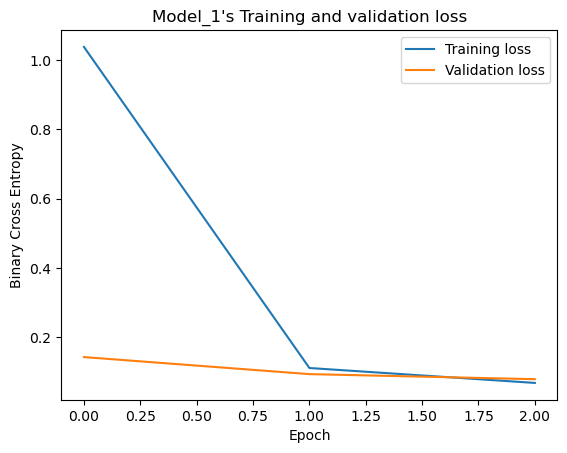

2023-04-03 01:20:00.590675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 133ms/step


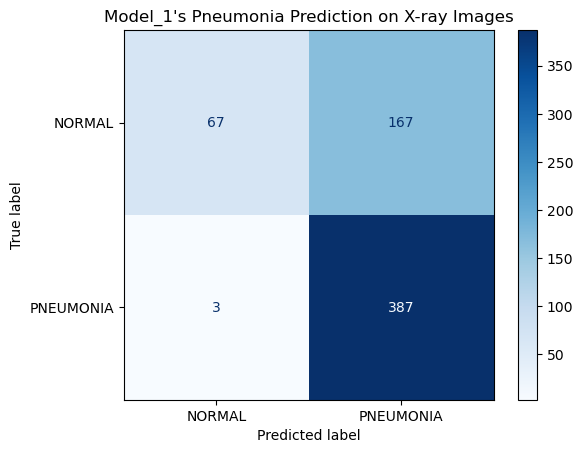

20/20 [==============================] - 3s 127ms/step
Model_1's accuracy: 0.728
Model_1's precision: 0.699
Model_1's recall: 0.992


In [36]:
# Save the model in the directory
save_model(model_1, 'model_1')

# Plot training history
plot_training_history(history_1, 'model_1')

# Display confusion matrix
plot_model_confusion_matrix(model_1, 'model_1')

# Display and save metrics
display_save_model_metrics(model_1, 'model_1')

This is an impressive benchmark to start with. We will see if we can further develope the model in search of better metrics. The goal is to make significant increase on precision, without hurting recall.

### Second Model
In the second model, we will add more combination convolutional and max-pooling layers in the early stages of hidden layers and add more dense layers right before the output layer.

In [15]:
# Define the model
model_2 = Sequential()
    
# Define input layer
model_2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))

# Define hidden layers
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))         
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))

# Define output layer
model_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=Precision())

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_2 = model_2.fit(train_data, 
                        epochs=10, 
                        validation_data=val_data, 
                        callbacks=[early_stopping])

Epoch 1/10


2023-04-02 23:46:35.673600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.3167 - precision_1: 0.8998

2023-04-02 23:47:12.994291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 45s 335ms/step - loss: 0.3167 - precision_1: 0.8998 - val_loss: 0.1429 - val_precision_1: 0.9655
Epoch 2/10
131/131 [==============================] - 46s 350ms/step - loss: 0.1196 - precision_1: 0.9654 - val_loss: 0.1180 - val_precision_1: 0.9769
Epoch 3/10
131/131 [==============================] - 45s 345ms/step - loss: 0.0866 - precision_1: 0.9710 - val_loss: 0.1385 - val_precision_1: 0.9959
Epoch 4/10
131/131 [==============================] - 45s 343ms/step - loss: 0.0728 - precision_1: 0.9757 - val_loss: 0.1059 - val_precision_1: 0.9907
Epoch 5/10
131/131 [==============================] - 45s 344ms/step - loss: 0.0517 - precision_1: 0.9830 - val_loss: 0.1134 - val_precision_1: 0.9731
Epoch 6/10
131/131 [==============================] - 47s 361ms/step - loss: 0.0351 - precision_1: 0.9910 - val_loss: 0.1171 - val_precision_1: 0.9907
Epoch 7/10
131/131 [==============================] - 47s 360ms/step - loss: 0.0306 - precision_1: 0.9923

In [16]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 82944)             0         
                                                                 
 dense_1 (Dense)             (None, 512)              

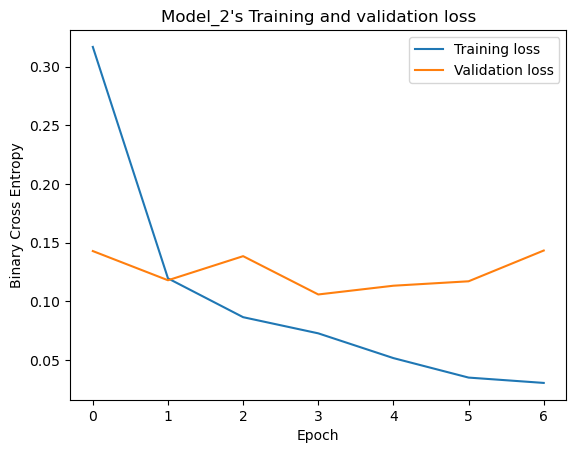

2023-04-02 23:51:58.315403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 147ms/step


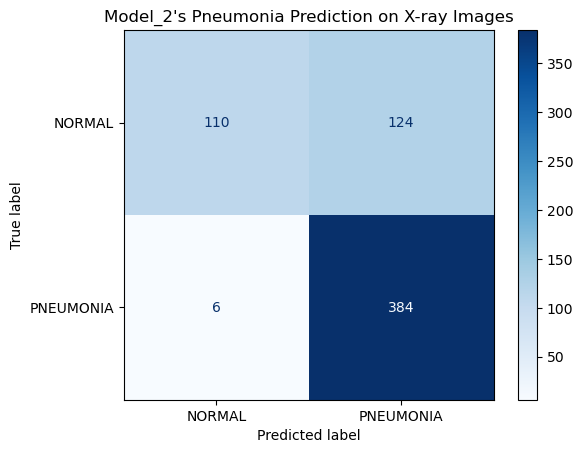

20/20 [==============================] - 3s 144ms/step
Model_2's accuracy: 0.792
Model_2's precision: 0.756
Model_2's recall: 0.985


In [17]:
# Save the model in the directory
save_model(model_2, 'model_2')

# Plot training history
plot_training_history(history_2, 'model_2')

# Display confusion matrix
plot_model_confusion_matrix(model_2, 'model_2')

# Display and save metrics
display_save_model_metrics(model_2, 'model_2')

The recall increased a little at the cost of decreased accuracy. Overall, the performance metrics is similar to the first baseline model.

### Third Model
In this model we will use batch normalization multiple times in between hidden layers.

In [18]:
# Define the model
model_3 = Sequential()
    
# Define layers
model_3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))

model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Conv2D(64, (3, 3), activation='relu'))

model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Conv2D(128, (3, 3), activation='relu'))

model_3.add(BatchNormalization())
model_3.add(MaxPooling2D((2, 2)))    

model_3.add(BatchNormalization())

model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.2))

model_3.add(BatchNormalization())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.25))

model_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=Precision())

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model
history_3 = model_3.fit(train_data, 
                        epochs=10, 
                        validation_data=val_data, 
                        callbacks=[early_stopping])

Epoch 1/10


2023-04-02 23:55:25.030125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.1305 - precision_2: 0.9693

2023-04-02 23:56:00.197632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 42s 314ms/step - loss: 0.1305 - precision_2: 0.9693 - val_loss: 2.2648 - val_precision_2: 0.7426
Epoch 2/10
131/131 [==============================] - 40s 307ms/step - loss: 0.0774 - precision_2: 0.9791 - val_loss: 4.0982 - val_precision_2: 0.7426
Epoch 3/10
131/131 [==============================] - 41s 314ms/step - loss: 0.0758 - precision_2: 0.9835 - val_loss: 2.6338 - val_precision_2: 0.7426
Epoch 4/10
131/131 [==============================] - 41s 312ms/step - loss: 0.0583 - precision_2: 0.9855 - val_loss: 5.5926 - val_precision_2: 0.7426


In [19]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                      

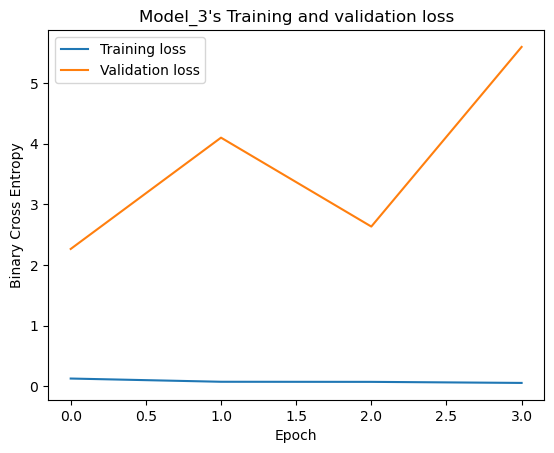

2023-04-02 23:58:09.868255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 136ms/step


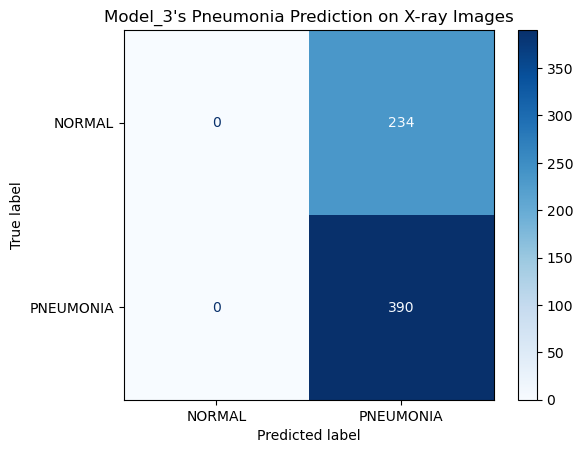

20/20 [==============================] - 3s 135ms/step
Model_3's accuracy: 0.625
Model_3's precision: 0.625
Model_3's recall: 1.0


In [20]:
# Save the model in the directory
save_model(model_3, 'model_3')

# Plot training history
plot_training_history(history_3, 'model_3')

# Display confusion matrix
plot_model_confusion_matrix(model_3, 'model_3')

# Display and save metrics
display_save_model_metrics(model_3, 'model_3')

The perfect recall is a good thing, but the prediction accuracy is pathetic. This model is still not reliable.

### Fourth Model
In this model, we will make a similar model to the previous one, except with learning scheduler.

In [21]:
model_4 = Sequential()

# Define layers
model_4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Conv2D(64, (3, 3), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Conv2D(128, (3, 3), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Conv2D(256, (3, 3), activation='relu'))
model_4.add(BatchNormalization())
model_4.add(MaxPooling2D((2, 2)))

model_4.add(Flatten())
model_4.add(Dense(512, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))

model_4.add(Dense(256, activation='relu'))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.5))

model_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_4.compile(optimizer='adam', loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-5)

# Train the model
history_4 = model_4.fit(train_data, 
                      epochs=10, 
                      validation_data=val_data, 
                      callbacks=[early_stopping, lr_scheduler])

Epoch 1/10


2023-04-03 00:00:01.346156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.2518 - precision_3: 0.9646 - recall: 0.9115

2023-04-03 00:00:39.030502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 45s 331ms/step - loss: 0.2518 - precision_3: 0.9646 - recall: 0.9115 - val_loss: 2.2089 - val_precision_3: 0.7426 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 43s 331ms/step - loss: 0.1451 - precision_3: 0.9706 - recall: 0.9672 - val_loss: 1.4363 - val_precision_3: 0.7426 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 43s 329ms/step - loss: 0.1052 - precision_3: 0.9765 - recall: 0.9759 - val_loss: 1.1570 - val_precision_3: 0.7426 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 0.0838 - precision_3: 0.9820 - recall: 0.9826
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
131/131 [==============================] - 42s 317ms/step - loss: 0.0838 - precision_3: 0.9820 - recall: 0.9826 - val_loss: 1.5028 - val_precision_3: 0.7426 - val_recall: 1.0000 - lr: 0.0010
Epoch 5/10
131/131 [==

In [22]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 148, 148, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                      

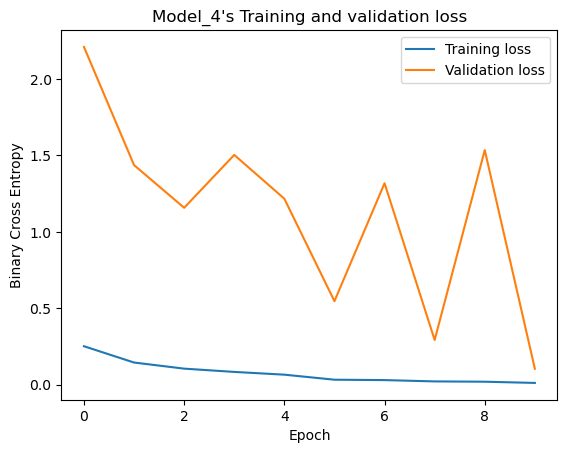

2023-04-03 00:07:09.661682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 134ms/step


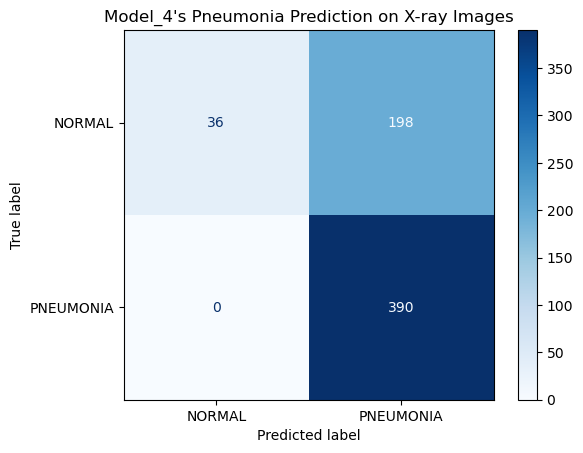

20/20 [==============================] - 3s 127ms/step
Model_4's accuracy: 0.683
Model_4's precision: 0.663
Model_4's recall: 1.0


In [23]:
# Save the model in the directory
save_model(model_4, 'model_4')

# Plot training history
plot_training_history(history_4, 'model_4')

# Display confusion matrix
plot_model_confusion_matrix(model_4, 'model_4')

# Display and save metrics
display_save_model_metrics(model_4, 'model_4')

We saw a sharp increase in accuracy, with a perfect recall. We will keep learning rate scheduler for the rest of our models.

### Fifth Model
With our fifth model, we will first introduce VGG16, a powerful tool for image classification, which uses a deep convolutional neural network architecture consisting of many layers with small kernel sizes, max pooling layers for downsampling, and fully connected layers for classification.

In [24]:
# Load the VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional base
base_model.trainable = False

# Define the model
model_5 = Sequential()
    
# Add the convolutional base as a layer
model_5.add(base_model)
          
# Define layers
model_5.add(Flatten())
model_5.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_5.add(Dropout(0.5))
model_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=Precision())

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-5)

# Fine-tune the model
history_5 = model_5.fit(train_data, 
                        epochs=10, 
                        validation_data=val_data, 
                        callbacks=[early_stopping, lr_scheduler])

# Save the model in the directory
model_5.save(os.path.join('models', 'model_5.h5'))

Epoch 1/10


2023-04-03 00:09:28.528225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 1.1892 - precision_4: 0.9446

2023-04-03 00:10:52.337602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 105s 795ms/step - loss: 1.1892 - precision_4: 0.9446 - val_loss: 0.2756 - val_precision_4: 0.9768 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 105s 804ms/step - loss: 0.2482 - precision_4: 0.9652 - val_loss: 0.2519 - val_precision_4: 0.9972 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 109s 836ms/step - loss: 0.2187 - precision_4: 0.9632 - val_loss: 0.2464 - val_precision_4: 0.9138 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 108s 821ms/step - loss: 0.1926 - precision_4: 0.9676 - val_loss: 0.1835 - val_precision_4: 0.9894 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - 111s 844ms/step - loss: 0.1788 - precision_4: 0.9693 - val_loss: 0.1821 - val_precision_4: 0.9919 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - 110s 843ms/step - loss: 0.1921 - precision_4: 0.9682 - val_loss: 0.1633 - val_precision_4: 0.9744 - lr: 0.0010
Epoch 7/10
131/131 [=

In [25]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


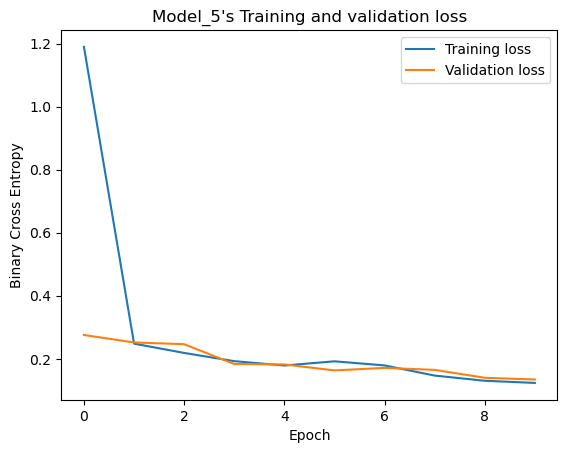

2023-04-03 00:27:24.432516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 11s 512ms/step


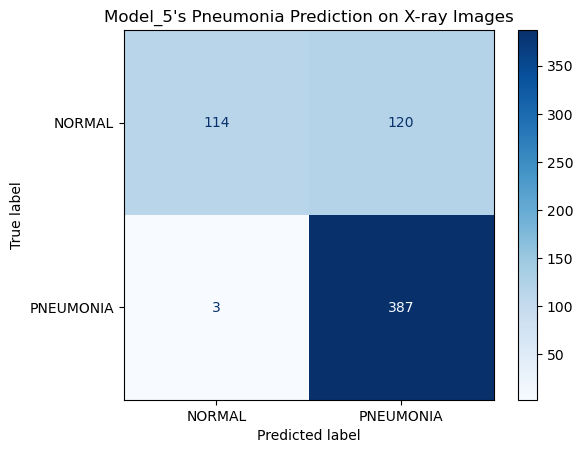

20/20 [==============================] - 10s 487ms/step
Model_5's accuracy: 0.803
Model_5's precision: 0.763
Model_5's recall: 0.992


In [26]:
# Save the model in the directory
save_model(model_5, 'model_5')

# Plot training history
plot_training_history(history_5, 'model_5')

# Display confusion matrix
plot_model_confusion_matrix(model_5, 'model_5')

# Display and save metrics
display_save_model_metrics(model_5, 'model_5')

We've got our best model so far. Let's add little more dense layers to the next model we work on.

### Sixth Model

In [27]:
# Define the model
model_6 = Sequential()

# Add the convolutional base as a layer
model_6.add(base_model)

# Add BatchNormalization layer
model_6.add(BatchNormalization())

# Define layers
model_6.add(Flatten())
model_6.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(Dropout(0.5))
model_6.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_6.add(Dropout(0.5))
model_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_6.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision()])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-5)

# Fine-tune the model
history_6 = model_6.fit(train_data, 
                        epochs=10, 
                        validation_data=val_data, 
                        callbacks=[early_stopping, lr_scheduler])

Epoch 1/10


2023-04-03 00:34:48.929216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 2.7016 - precision_5: 0.9382

2023-04-03 00:36:13.408459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 105s 797ms/step - loss: 2.7016 - precision_5: 0.9382 - val_loss: 1.2780 - val_precision_5: 0.9881 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 109s 833ms/step - loss: 0.8024 - precision_5: 0.9775 - val_loss: 0.6065 - val_precision_5: 0.9671 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 108s 824ms/step - loss: 0.4594 - precision_5: 0.9813 - val_loss: 0.3987 - val_precision_5: 0.9920 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 109s 836ms/step - loss: 0.3472 - precision_5: 0.9791 - val_loss: 0.3671 - val_precision_5: 1.0000 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - 109s 829ms/step - loss: 0.2734 - precision_5: 0.9839 - val_loss: 0.2825 - val_precision_5: 0.9528 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - 109s 835ms/step - loss: 0.2410 - precision_5: 0.9829 - val_loss: 0.2279 - val_precision_5: 0.9660 - lr: 0.0010
Epoch 7/10
131/131 [=

In [28]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 batch_normalization_11 (Bat  (None, 4, 4, 512)        2048      
 chNormalization)                                                
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                      

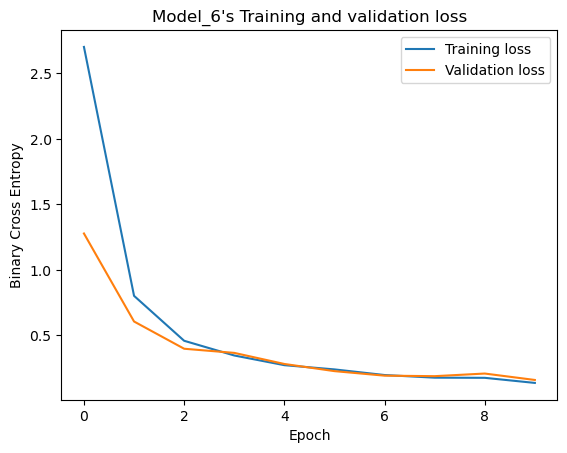

2023-04-03 00:52:41.071230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 10s 494ms/step


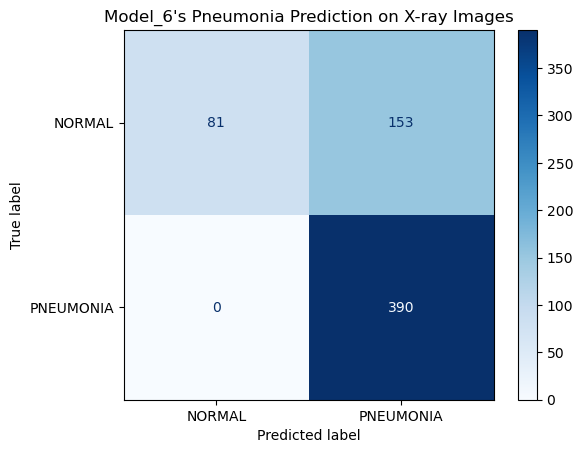

20/20 [==============================] - 10s 503ms/step
Model_6's accuracy: 0.755
Model_6's precision: 0.718
Model_6's recall: 1.0


In [29]:
# Save the model in the directory
save_model(model_6, 'model_6')

# Plot training history
plot_training_history(history_6, 'model_6')

# Display confusion matrix
plot_model_confusion_matrix(model_6, 'model_6')

# Display and save metrics
display_save_model_metrics(model_6, 'model_6')

### Seventh Model
In this we will include l2 regularization technique.

In [31]:
# Define the model
model_7 = Sequential()

# Add the convolutional base as a layer
model_7.add(base_model)

# Add BatchNormalization layer
model_7.add(BatchNormalization())

# Define layers
model_7.add(Flatten())
model_7.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_7.add(Dropout(0.5))
model_7.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_7.add(Dropout(0.5))
model_7.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_7.add(Dropout(0.5))
model_7.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

# Compile the model
model_7.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision()])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, min_lr=1e-5)

# Fine-tune the model
history_7 = model_7.fit(train_data, 
                        epochs=10, 
                        validation_data=val_data, 
                        callbacks=[early_stopping, lr_scheduler])

Epoch 1/10


2023-04-03 00:57:25.655837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 5.8672 - precision_7: 0.9334

2023-04-03 00:58:52.077468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 107s 813ms/step - loss: 5.8672 - precision_7: 0.9334 - val_loss: 2.7450 - val_precision_7: 0.9577 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - 105s 800ms/step - loss: 1.7770 - precision_7: 0.9678 - val_loss: 1.2534 - val_precision_7: 0.9744 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - 106s 812ms/step - loss: 0.9579 - precision_7: 0.9737 - val_loss: 0.7471 - val_precision_7: 0.9921 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - 105s 799ms/step - loss: 0.5997 - precision_7: 0.9794 - val_loss: 0.5204 - val_precision_7: 0.9907 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - 105s 806ms/step - loss: 0.4277 - precision_7: 0.9804 - val_loss: 0.3720 - val_precision_7: 0.9783 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - 104s 795ms/step - loss: 0.3143 - precision_7: 0.9802 - val_loss: 0.3053 - val_precision_7: 0.9933 - lr: 0.0010
Epoch 7/10
131/131 [=

In [32]:
model_7.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 batch_normalization_13 (Bat  (None, 4, 4, 512)        2048      
 chNormalization)                                                
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_19 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                      

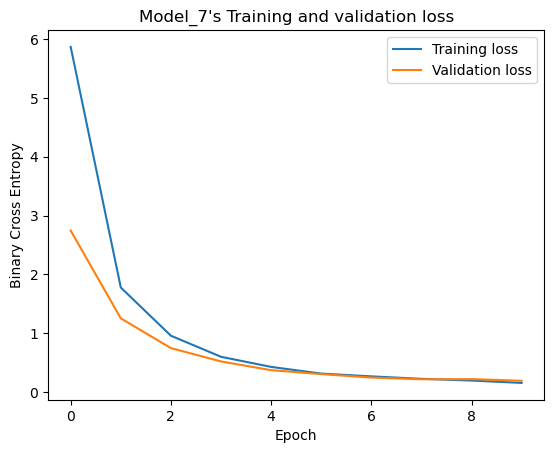

2023-04-03 01:17:27.119024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 10s 454ms/step


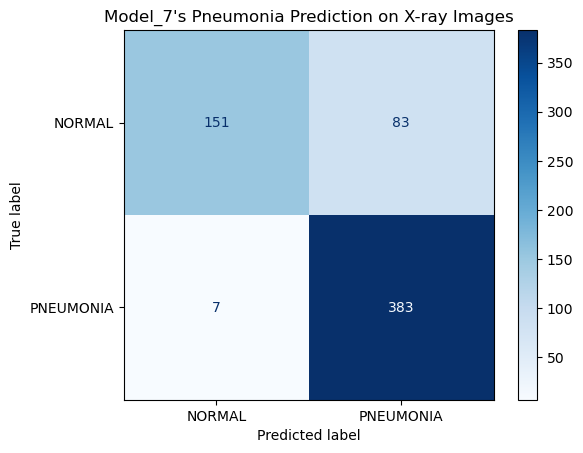

20/20 [==============================] - 9s 449ms/step
Model_7's accuracy: 0.856
Model_7's precision: 0.822
Model_7's recall: 0.982


In [33]:
# Save the model in the directory
save_model(model_7, 'model_7')

# Plot training history
plot_training_history(history_7, 'model_7')

# Display confusion matrix
plot_model_confusion_matrix(model_7, 'model_7')

# Display and save metrics
display_save_model_metrics(model_7, 'model_7')

## Evaluation

We will now compare the performance metrics of each model.

In [47]:
# Create a dataframe of models' results
models_results_df = pd.DataFrame(models_results_dict)

In [53]:
models_results_df

,model,accuracy,precision,recall
0,Model_1,0.728,0.699,0.992
2,Model_2,0.792,0.756,0.985
3,Model_3,0.625,0.625,1.000
4,Model_4,0.683,0.663,1.000
5,Model_5,0.803,0.763,0.992
6,Model_6,0.755,0.718,1.000
7,Model_7,0.856,0.822,0.982


We will now visualize this.

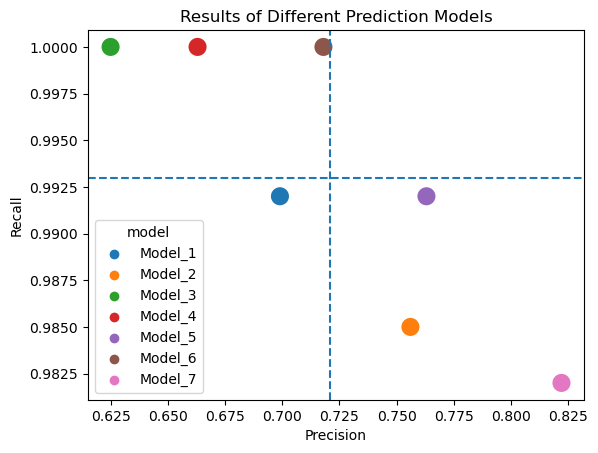

In [65]:
# Create visualizations
sns.scatterplot(x='precision', y='recall', hue='model', s=200, data=models_results_df)
plt.title("Results of Different Prediction Models")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.axhline(models_results_df['recall'].mean(), linestyle='--')
plt.axvline(models_results_df['precision'].mean(), linestyle='--')
plt.show()

We will choose the fifth model to be our final model.
It increased the precision score by 0.075 while retaining the recall score.
Seventh model's superb performance on precision was in exchange for increased false negatives, so thus is unwelcome.

Also we will generate images of false negatives because that's something we eventually want to get rid of. It's noteworthy to look into it.

In [67]:
y_pred_prob = model_5.predict(test_data)
y_pred = np.round(y_pred_prob).flatten()

# Get the true labels from the test data
y_true = test_data.classes

20/20 [==============================] - 9s 464ms/step


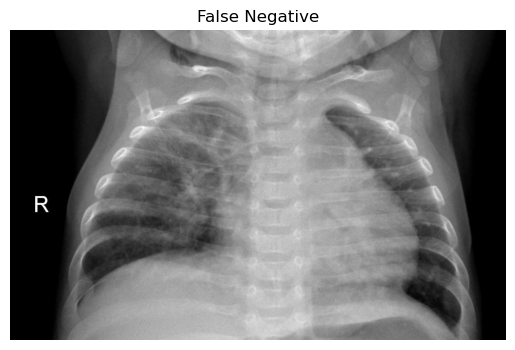

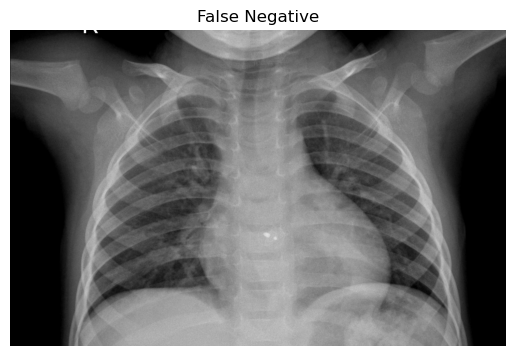

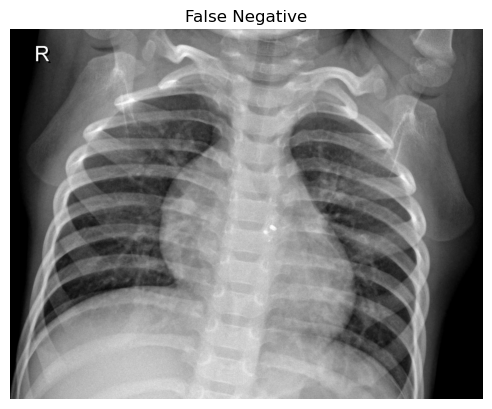

In [68]:
# Find the indices of the false negative samples
false_negatives = np.where((y_true == 1) & (y_pred == 0))[0]

# Plot the false negative images
import matplotlib.pyplot as plt

for i in false_negatives:
    image_path = os.path.join(test_dir, test_data.filenames[i])
    image = plt.imread(image_path)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("False Negative")
    plt.show()

In [69]:
# Also see what files were false negatives
for i in false_negatives:
    image_path = os.path.join(test_dir, test_data.filenames[i])
    print(image_path)

data/modified/test/PNEUMONIA/person127_bacteria_604.jpeg
data/modified/test/PNEUMONIA/person153_bacteria_726.jpeg
data/modified/test/PNEUMONIA/person154_bacteria_728.jpeg


These three pictures are exactly what we want to improve to correctly predict in the future.
They are all bacterial infections.

## Conclusion

We were able to retain the recall score from our simple baseline model but went on to increase precision score noticeably. However, we believe that further furnishing models can lead to even better outcomes.

Mount Sinai can improve their pneumonia detection process, save money, staff, and space by taking advantage of this model.

In order to improve the accuracy and fairness of the lung disease detection project, our next steps involve collecting more data, particularly X-ray images of healthy lungs, as well as gathering data from a more diverse population. Specifically, we aim to acquire data from men and individuals outside of China, as the current dataset may not provide a representative sample of the general population.